In [105]:
#convert that column to int, showing which element is not a number

In [59]:
import numpy as np
import pandas as pd


from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.gaussian_process import GaussianProcessRegressor

import pickle

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
%matplotlib inline
import scipy


In [88]:
def preprocess(file_path,y_label,ratio= 0.99,threshold = 0.9):
    
    tr_te = pd.read_excel(file_path, sheetname='Sheet1')
    tr_te = pd.get_dummies(tr_te)
    tr_te = tr_te.loc[:, tr_te.var() != 0.0]

    drop_names = []
    for col_name in tr_te.columns:
        PCC = scipy.stats.pearsonr(tr_te[y_label],tr_te[col_name])[0]
        if abs(PCC) > threshold:
            drop_names.append(col_name)
    drop_names.append('ev_rolledback')
    drop_names.append(y_label)

    tr_te  = tr_te.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    X = tr_te.drop(drop_names, axis = 1)

    features = X.columns
    X = X.values
    Y = tr_te[y_label].values

    num = X.shape[0]
    num_tr = int(num*ratio)

    xtrain = X
    y = Y
    print("x shape: ", xtrain.shape)

    return (xtrain,y)

In [89]:
def cross_val(xtrain,y,xtest):
    nfolds = 5
    folds = KFold(len(y), n_folds = nfolds, shuffle = True, random_state = 2018)

    # create two arrays to hold the prediction on training set and testing set
    preds_train = np.zeros(xtrain.shape[0])
    preds_test = np.zeros(xtest.shape[0])

    fold_index = 1
    for (inTr, inVal) in folds:
        # split the training set 
        xtr = xtrain[inTr]
        ytr = y[inTr]
        xval = xtrain[inVal] 
        yval = y[inVal]

        # Define a isotropic Matern kernel
        kernel_Matern = 1.0 * Matern([1.0]*xtrain.shape[1])

        # train and save the trained model
        file_name = '../trained_model/gp'+str(fold_index)+".sav"
        gp = GaussianProcessRegressor(kernel = kernel_Matern, n_restarts_optimizer=1)
        gp.fit(xtr, ytr)
        pickle.dump(gp, open(file_name, 'wb'))

        # predict on the validation set
        pred = gp.predict(xval, return_std=False)
        score = mean_absolute_error(yval, pred)
        preds_train[inVal] = pred
        print('Fold ', fold_index, '- MAE:', score)
        fold_index += 1

    return preds_train
 

In [90]:
#visualize an output column with each input column in Xs
def visualize(y,Xs):
    fig, axs = plt.subplots(5,4, figsize=(20, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 1, wspace=1)

    axs = axs.ravel()

    for i in range(Xs.shape[1]):

        y2 = Xs[:,i]
        axs[i].scatter(y,y2)

        PCC = round(scipy.stats.pearsonr(y,y2)[0],3)

        axs[i].text(np.min(y)*1.1, 0.95*np.max(y2), r'PCC='+str(PCC),
             fontsize=10)

In [91]:
def visualize_pre(ytest,preds_test):
    fig = plt.figure(figsize= (6,4))

    plt.scatter(ytest,preds_test)
    plt.xlabel('Truth')
    plt.ylabel('Prediction')

    PCC = round(scipy.stats.pearsonr(ytest,preds_test)[0],3)

    plt.text(np.min(ytest)*1.1, 0.95*np.max(preds_test), r'PCC='+str(PCC),
             fontsize=10)

In [92]:
def predict(y_label,threshold_):
    file_path = "../data/dfly-scaling-data.xlsx"
    xtrain, y = preprocess(file_path, y_label,threshold = threshold_)
    preds_train = cross_val(xtrain,y,xtest)
    visualize_pre(y,preds_train)

x shape:  (629, 13)
Fold  1 - MAE: 0.000348629361004
Fold  2 - MAE: 0.000456556354576
Fold  3 - MAE: 0.000525780419818
Fold  4 - MAE: 0.000342045694145
Fold  5 - MAE: 0.000342309848618


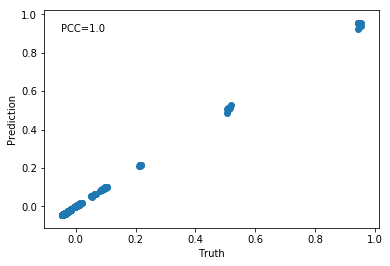

In [99]:
y_labels = ['ev_rolledback','runtime']
threshold_ = 0.4 #threhold for screening which column to use for prediction
y_label = y_labels[0]
predict(y_label, threshold_ )

x shape:  (629, 13)


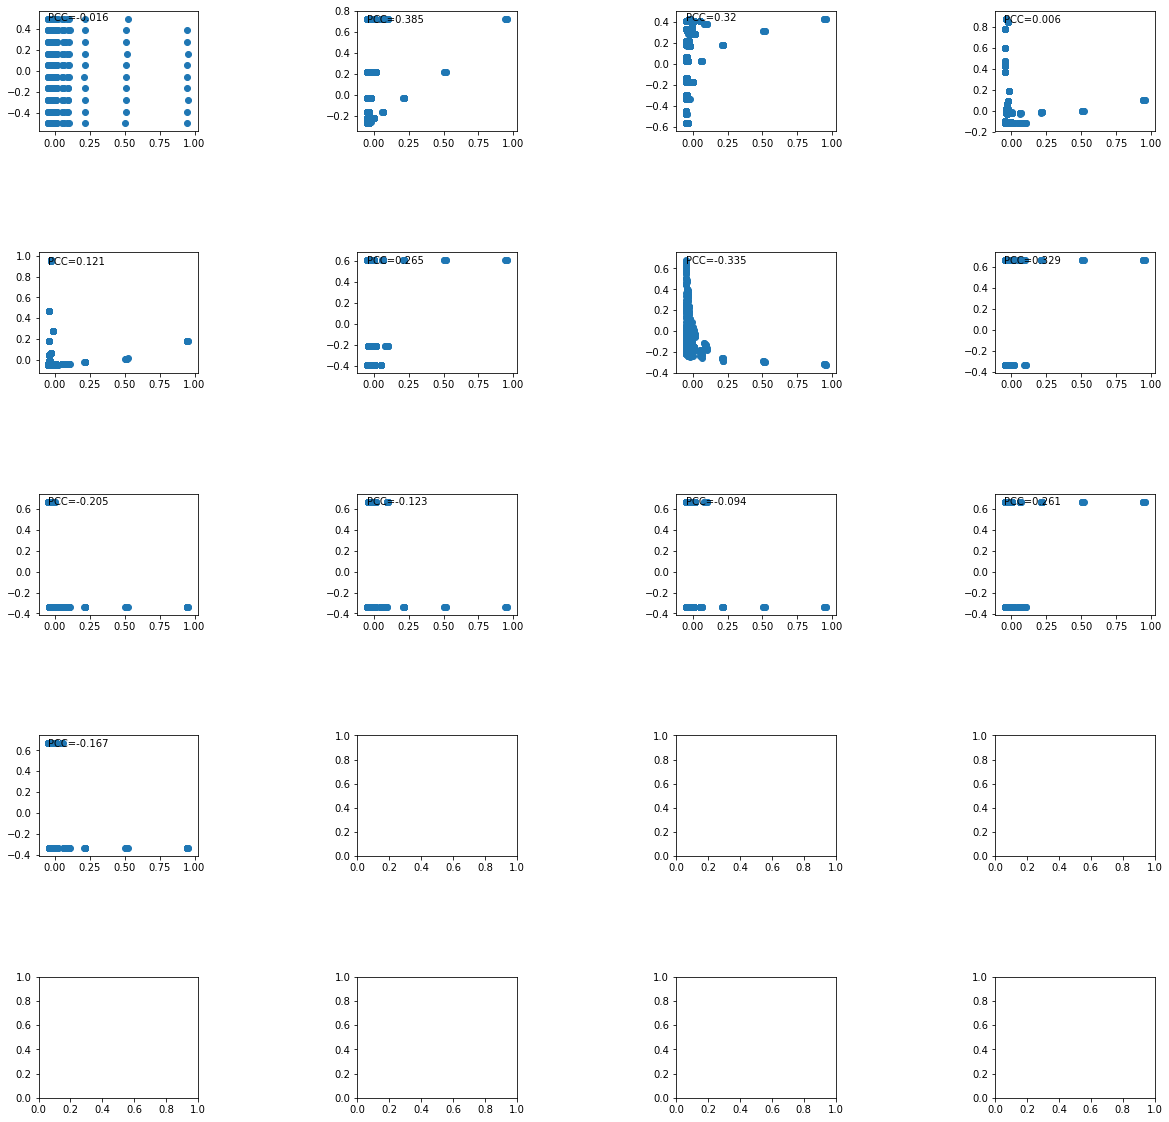

In [100]:
xtrain, y = preprocess(file_path, y_label,threshold = threshold_ )
visualize(y,xtrain)

x shape:  (629, 10)
Fold  1 - MAE: 0.00780003718478
Fold  2 - MAE: 0.0101215699646
Fold  3 - MAE: 0.0070784037689
Fold  4 - MAE: 0.00648156848383
Fold  5 - MAE: 0.00748578475992


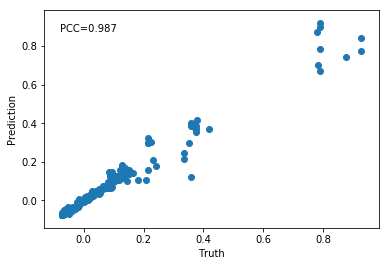

In [101]:
y_label = y_labels[1]
predict(y_label,threshold_)

x shape:  (629, 10)


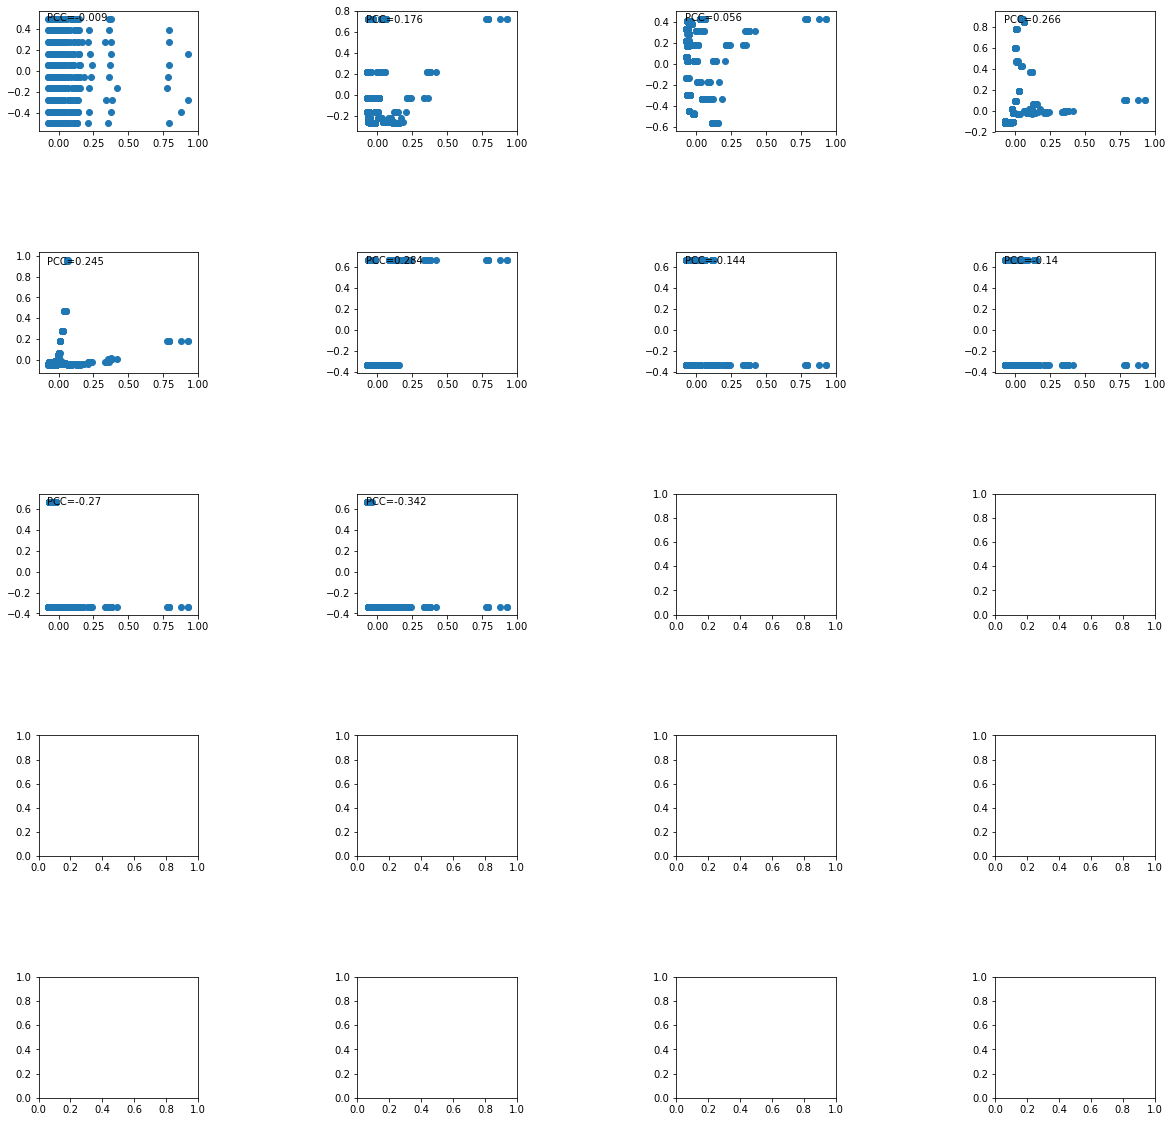

In [102]:
xtrain, y = preprocess(file_path, y_label,threshold = threshold_ )
visualize(y,xtrain)